In [1]:
from utils.analysis.tools import simDir, periodicity_plot
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm import tqdm
from utils import plot
from utils.plot import _FIGURE_DIR, get_size_inches, _CM
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl

In [2]:
class periodicityPhaseDiagram:
    def __init__(self,
                 directory: str,
                 sweep_file: str = "sweep_parameters.txt"):
        self.sweep_directory = Path(directory)
        self.sweep_file = self.sweep_directory / sweep_file
        self.sweep_parameters = [line.split(",")[0] for line in self.sweep_file.read_text().splitlines()]

    def extract_data(self):
        simdir_paths = [file.parent for file in self.sweep_directory.glob("./*/input_params.txt")]
        processes = mp.Pool(8-1)
        self.results = tqdm(processes.imap(self.worker,simdir_paths),total=len(simdir_paths))
        self.df = pd.DataFrame(self.results)
    
    def worker(self,worker_input):
        simdir_path = worker_input
        sim = simDir(simdir_path)
        param_values = sim.params
        relevant_params = {parameter: str(param_values[parameter]) for parameter in self.sweep_parameters}
        sim.run()
        sim.rna()
        sim.condensate()
        sim.periodicity(15000)
        period = np.diff(sim.time[sim.peaks],axis=0).mean()
        shortest = np.min([sim.peaks.shape,sim.troughs.shape])
        peaks = sim.peaks[:shortest]
        troughs = sim.troughs[:shortest]
        com_height = np.abs(sim.com[peaks,0]-sim.com[troughs,0]).mean()
        radius_variance_height = np.abs(sim.radius_variance[peaks]-sim.radius_variance[troughs]).mean()
        eccentricity_height = np.abs(sim.eccentricity[peaks]-sim.eccentricity[troughs]).mean()
        rna_height = np.abs(sim.rna_amount[peaks]-sim.rna_amount[troughs]).mean()
        if troughs.size == 0 or peaks.size == 0:
            return relevant_params | {"period": period,
                                  "com_height": com_height,
                                  "radius_variance_height": radius_variance_height,
                                  "eccentricity_height": eccentricity_height,
                                  "rna_height": rna_height,
                                  "xy_trough_end": np.nan,
                                  "xy_peak_end": np.nan,
                                  "c_trough_end": np.nan,
                                  "c_peak_end": np.nan}
        else:
            xy_trough_end = sim.xy[sim.mask[troughs[-1],:]]
            c_trough_end = sim.concentration_profile[0][troughs[-1],:][sim.mask[troughs[-1],:]]
            xy_peak_end = sim.xy[sim.mask[peaks[-1],:]]
            c_peak_end = sim.concentration_profile[0][peaks[-1],:][sim.mask[peaks[-1],:]]
            return relevant_params | {"period": period,
                                    "com_height": com_height,
                                    "radius_variance_height": radius_variance_height,
                                    "eccentricity_height": eccentricity_height,
                                    "rna_height": rna_height,
                                    "xy_trough_end": xy_trough_end,
                                    "xy_peak_end": xy_peak_end,
                                    "c_trough_end": c_trough_end,
                                    "c_peak_end": c_peak_end}

In [3]:
# ppd = periodicityPhaseDiagram("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/05_TimeDelay/20240223_PhaseDiagramHillFaster")

In [4]:
# ppd.extract_data()

In [5]:
# ppd.df.to_pickle("20240223_PhaseDiagramHillFaster.pkl")

In [6]:
df = pd.read_pickle("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/05_Analysis/20240223_PhaseDiagramHillFasterMoreFixed.pkl")
df = df.query("not tau in [150, 250, 350]")

In [7]:
df["tau"] = df["tau"].astype(np.float64)
df["chiPR_tilde"] = df["chiPR_tilde"].astype(np.float64)
df["rna_height"] = df["rna_height"].astype(np.float64)

  ax.legend()



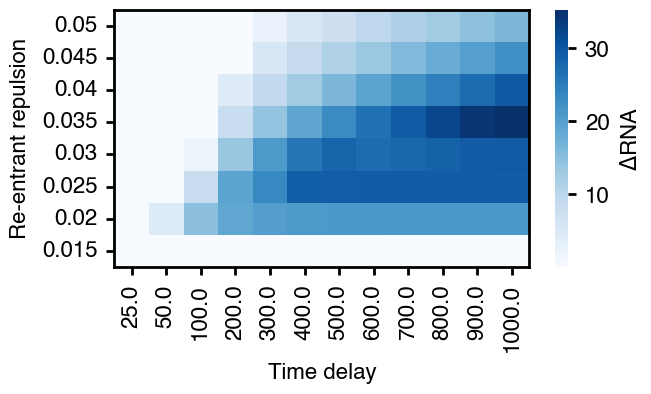

In [8]:
variable = "rna_height"
rna_pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable)
rna_pivot = rna_pivot.loc[::-1]
xlabel = "Time delay"
ylabel = "Re-entrant repulsion"
fig, ax = plt.subplots()
fig.set_size_inches(8.5*_CM,8.5*_CM*1/2)
sns.heatmap(rna_pivot,cmap="Blues",ax=ax,cbar_kws={"label":r"$\Delta$RNA"})
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

In [9]:
def add_iso_line(ax, value, color, pivot):
    v = (pivot.reset_index()[pivot.columns].gt(10).values - pivot.reset_index()[pivot.columns].gt(10).shift(1,axis=1).values).astype(np.float64)
    v = np.nan_to_num(v, nan=0).astype(bool)
    h = pivot.gt(value).diff(axis=0).fillna(False).to_numpy()
    
    try:
        l = np.argwhere(v.T)    
        vlines = np.array(list(zip(l, np.stack((l[:,0], l[:,1]+1)).T)))
        
        l = np.argwhere(h.T)    
        hlines = np.array(list(zip(l, np.stack((l[:,0]+1, l[:,1])).T)))
        
        lines = np.vstack((vlines, hlines))
        ax.add_collection(LineCollection(lines, lw=1, colors=color ))
    except:
        pass

  ax.legend()

  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90)

  h = pivot.gt(value).diff(axis=0).fillna(False).to_numpy()



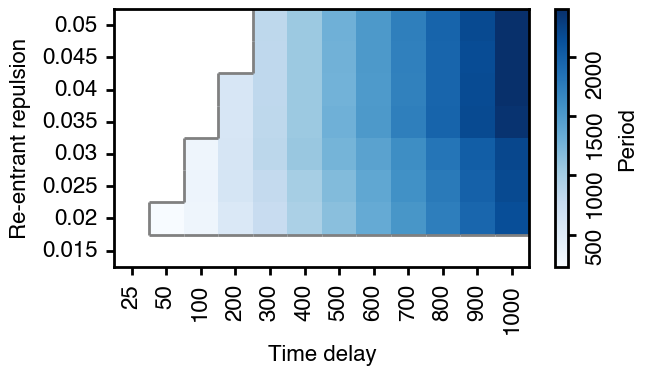

In [10]:
variable = "period"
period_pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable,dropna=False)
period_pivot.columns = period_pivot.columns.astype(int)
period_pivot[rna_pivot<2] = np.nan
period_pivot = period_pivot.loc[::-1]
xlabel = "Time delay"
ylabel = "Re-entrant repulsion"
fig, ax = plt.subplots()
fig.set_size_inches(8.5*_CM,8.5*_CM*1/2)
mini = np.nanmin(period_pivot)
maxi = np.nanmax(period_pivot)
g = sns.heatmap(period_pivot,cmap="Blues",ax=ax,cbar_kws={"label":"Period"},
                vmin = mini, vmax = maxi)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
for spine in ax.spines:
    ax.spines[spine].set_visible(True)
cbar = ax.collections[0].colorbar
cbar.outline.set_color('black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90)
add_iso_line(ax,1,"Grey",period_pivot)
fig.savefig(_FIGURE_DIR/"Fig3_PeriodPD")

  ax.legend()

  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90)

  h = pivot.gt(value).diff(axis=0).fillna(False).to_numpy()



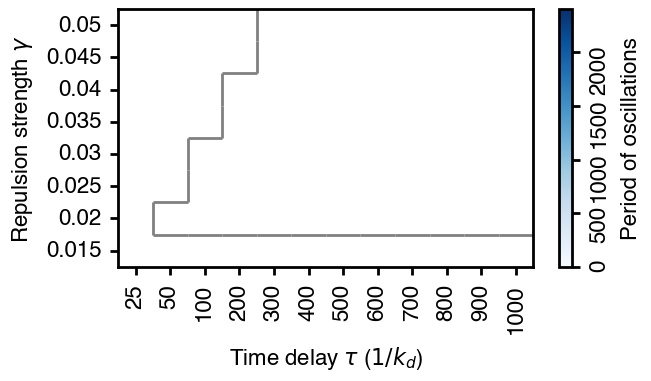

In [11]:
variable = "period"
period_pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable,dropna=False)
period_pivot.columns = period_pivot.columns.astype(int)
period_pivot[rna_pivot<2] = np.nan
period_pivot = period_pivot.loc[::-1]
xlabel = r"Time delay $\tau$ ($1/k_d$)"
ylabel = "Repulsion strength $\gamma$"
fig, ax = plt.subplots()
fig.set_size_inches(8.5*_CM,8.5*_CM*1/2)
# mini = np.nanmin(period_pivot)
maxi = np.nanmax(period_pivot)
period_pivotnan = period_pivot.copy()
period_pivotnan[:] = np.nan
g = sns.heatmap(period_pivotnan,cmap="Blues",ax=ax,cbar_kws={"label":"Period of oscillations"},
                vmin = 0, vmax = maxi)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
for spine in ax.spines:
    ax.spines[spine].set_visible(True)
cbar = ax.collections[0].colorbar
cbar.outline.set_color('black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90)
add_iso_line(ax,1,"Grey",period_pivot)
fig.savefig(_FIGURE_DIR/"Fig3_PeriodPD")

In [12]:
sim = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/05_TimeDelay/20240223_PhaseDiagramHillFaster/M1_1.0_b_-0.25_g_-0.1_c_0.03_k_0.05_kp_0.2_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_350.0_kd_1.0")
sim.run()
sim.condensate()
sim.rna()

In [13]:
def periodicity_plot(sim,threshold,leftlim=0,rightlim=20000):
    sim.periodicity(threshold)
    rna = np.ravel(sim.rna_amount)
    com = np.ravel(sim.com[:,0])
    time = np.ravel(sim.time)
    if time.size > com.size:
        time = time[:com.size]
    fig,axes = plt.subplots(4,1,sharex=True)
    fig.set_size_inches(5,3)
    axes[0].plot(time,rna)
    start = np.argmin((time-threshold)**2)
    axes[0].scatter(time[sim.peaks],rna[sim.peaks],alpha=0.3)
    axes[0].scatter(time[sim.troughs],rna[sim.troughs],alpha=0.3)
    diffs = np.diff(time[sim.peaks],axis=0)
    locst = (time[sim.peaks][:-1] + time[sim.peaks][1:])/2
    for i in range(len(diffs)):
        axes[0].annotate(f"{diffs[i].item():.0f}",(locst[i],0),ha='center',rotation=90,
                         va='bottom')
    axes[1].plot(time,com)
    axes[2].plot(time,np.var(sim.radius,axis=1))
    axes[3].plot(time,sim.eccentricity)
    [ax.axvline(i, color='grey', ls='dashed') for i in time[sim.peaks] for ax in axes]
    axes[3].set_xlabel("Time")
    axes[0].set_ylabel("RNA\nAmount")
    axes[1].set_ylabel("Center of\nMass")
    axes[2].set_ylabel("Variance of\nRadius")
    axes[3].set_ylabel("Eccentricity")
    axes[3].set_xlim(left=leftlim,right=rightlim)
    return fig,axes,sim.peaks,sim.troughs

(<Figure size 1000x600 with 4 Axes>,
 array([<Axes: ylabel='RNA\nAmount'>, <Axes: ylabel='Center of\nMass'>,
        <Axes: ylabel='Variance of\nRadius'>,
        <Axes: xlabel='Time', ylabel='Eccentricity'>], dtype=object),
 array([2282, 2474, 2666, 2858, 3051, 3243, 3435, 3627, 3819, 4012]),
 array([2167, 2360, 2552, 2744, 2936, 3129, 3321, 3513, 3705, 3898, 4090]))

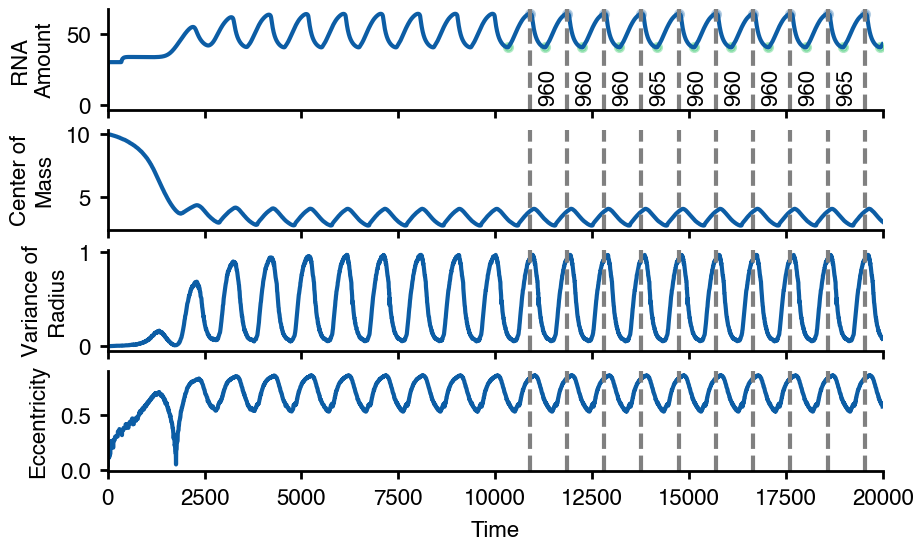

In [14]:
periodicity_plot(sim,threshold=10000)

In [15]:
c_white_trans = mpl.colors.colorConverter.to_rgba('white',alpha = 0)
c_white= mpl.colors.colorConverter.to_rgba('white',alpha = 1)
cmap_white = mpl.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_white_trans,c_white],512)
c_black_trans = mpl.colors.colorConverter.to_rgba('black',alpha = 0)
c_black= mpl.colors.colorConverter.to_rgba('black',alpha = 1)
cmap_black = mpl.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_black_trans,c_black],512)
def shape(xy,c,ax,cmap="Blues",vmin=None,vmax=None,xlim=None,ylim=None,levels=None):
    x = xy[:,0]
    y = xy[:,1]
    ax.tricontourf(x,y,c,cmap=cmap,
                   vmin=vmin,vmax=vmax,
                   levels=levels)
    ax.tricontour(x,y,c,
                   vmin=vmin,vmax=vmax,
                   levels=0,
                   linewidths=0.25,
                   colors="black")
    ax.set_aspect(1)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
        ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [16]:
mask_pivot = df.pivot(index="chiPR_tilde",columns="tau",values=["xy_peak_end", "c_peak_end"])
mask_pivot = mask_pivot.loc[::-1]

In [17]:
arr_xy = mask_pivot["xy_peak_end",].to_numpy().flatten()[0]
arr_c = mask_pivot["c_peak_end",].to_numpy().flatten()[0]
period = period_pivot.to_numpy().flatten()[0]

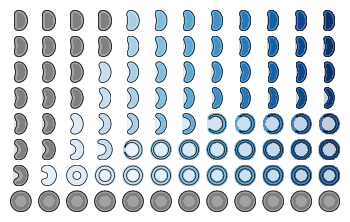

In [18]:
cmap = mpl.colormaps['Blues']
periods = period_pivot.to_numpy().flatten()
# vmin = np.nanmin(periods)
vmax = np.nanmax(periods)
norm = mcolors.Normalize(vmin=0, vmax=vmax)


mask_pivot = df.pivot(index="chiPR_tilde",columns="tau",values=["xy_peak_end", "c_peak_end"])
mask_pivot = mask_pivot.loc[::-1]
fig,axes=plt.subplots(len(mask_pivot["xy_peak_end"].index),len(mask_pivot["xy_peak_end"].columns))
fig.set_size_inches(5.437*_CM,3.335*_CM)
for ax,arr_xy,arr_c,period,rna_height in zip(axes.flatten(),
                           mask_pivot["xy_peak_end",].to_numpy().flatten(),
                           mask_pivot["c_peak_end",].to_numpy().flatten(),
                           period_pivot.to_numpy().flatten(),
                           rna_pivot.to_numpy().flatten()):

    # Create a colormap that transitions from transparent to fully opaque
    if not np.isnan(period):
        c_full = cmap(norm(period))  # Color corresponding to the period
        c_trans = (1, 1, 1, 1)  # Transparent
        c_full = (*c_full[:3], 1)  # Make it fully opaque
    else:
        c_full = mcolors.to_rgba("grey")
        c_trans = (1, 1, 1, 1)  # Transparent
        c_full = (*c_full[:3], 1)  # Make it fully opaque
    # Create a linear segmented colormap from transparent to full color
    cmap_transparent = mpl.colors.LinearSegmentedColormap.from_list('transparent_to_full', [c_trans, c_full], 512)

    # Assuming 'shape' is a function defined elsewhere to plot the contour
    shape(arr_xy, arr_c, ax, cmap_transparent, levels=1, vmax=np.max(arr_c))
plt.savefig(_FIGURE_DIR / "Fig_Oscillations_Overlay.pdf",transparent=True)